In [1]:
import numpy as np
import pandas as pd
from enum import Enum

import matplotlib.pyplot as plt
from math import sqrt, log, exp, pi
from scipy.stats import gmean, kurtosis

## Task 1

In this task we will explore the valuation of Asian style options in setup of standard Black-Scholes-Merton (1973) assumptions utilising Monte-Carlo simulations. Also we will compare different numerical schemes that can be used to simulate the asset.

Consider Gemetric Brownian Motion model for stock for a stock with following parameters:
$$S_0 = 100$$
$$T = 1 year$$
$$ \sigma = 20\%$$
$$t = 5\%,$$
where parameters are initial stock price, time horizon, volaility and constant risk-free rate in corresponding order.
Under risk-neutral measure the stochastic differential equation (SDE) that simulates the asset price will have the following form:
$$dS_t = r S_t dt + \sigma S_t dW_t,$$
where $S_t$ is the underlying asset price at time $t$, parameters $r, \sigma$ are constant and defined above and $W_t$ is Brownian motion.
In order to obtain a discrete simulation of the process we will utilise three methods: closed form solution, Euler-Maruyama scheme and Milstein scheme.

Closed form solution:
$$S_t = S_0 \exp\left((r - \frac{1}{2}\sigma^2)t + \sigma W_t\right)$$

Euler-Maruyama scheme:
$$S_{t+\delta t} = S_t + rS_t\delta t + \sigma S_t\sqrt{\delta t}\omega$$

Milstein scheme:
$$S_{t+\delta t} = S_t + rS_t\delta t + \sigma S_t\sqrt{\delta t}\omega + \frac{1}{2}\sigma^2S_t\left(\omega^2 - 1\right)\delta t,$$
where $\omega$ is stnadard normal random variable and $\delta t$ is time step. Note that last two are numerical aproximation schemes with accuracy of $O(\sqrt{\delta t})$ and $O(\delta t)$ correspondingly. Now we will implement the simulation to compare the results

In [2]:
def normal_sample(N, k=1, random_state=None):
    np.random.seed(random_state)
    return np.random.normal(0, 1, size=(k, N))

def brownian_motion(T, N, k=1, random_state=None):
    dW = normal_sample(N, k, random_state) * sqrt (T / N)
    return np.insert(dW.cumsum(axis=1), 0, 0, 1)

def GBM(T, N, mu, sigma, S_0, k=1, random_state=None):
    time = np.linspace(0, T, N+1)
    W = brownian_motion(T, N, k, random_state)
    S = S_0 * np.exp((mu - (sigma ** 2) / 2) * time + sigma * W)
    return (S)

def GBM_EM(T, N, mu, sigma, S_0, k=1, random_state=None):
    dt = T / N
    time = np.linspace(0, T, N+1)
    dW = normal_sample(N, k, random_state) * sqrt (T / N)
    S = np.zeros((k, N+1))
    S[:,0] = S_0
    for n in range(N):
        S[:,n+1] = S[:, n] + mu * S[:, n] * dt + S[:, n] * sigma * dW[:, n]
    return (S)

def GBM_M(T, N, mu, sigma, S_0, k=1, random_state=None):
    dt = T / N
    time = np.linspace(0, T, N+1)
    dW = normal_sample(N, k, random_state) * sqrt (T / N)
    S = np.zeros((k, N+1))
    S[:,0] = S_0
    for n in range(N):
        S[:,n+1] = S[:, n] + mu * S[:, n] * dt + S[:, n] * sigma * dW[:, n] + \
        0.5 * (sigma ** 2) * S[:, n] * (dW[:, n]**2 - dt)
    return (S)

In [3]:
T = 1
r = 0.05
sigma = 0.2
S_0 = 100
day_count = 252

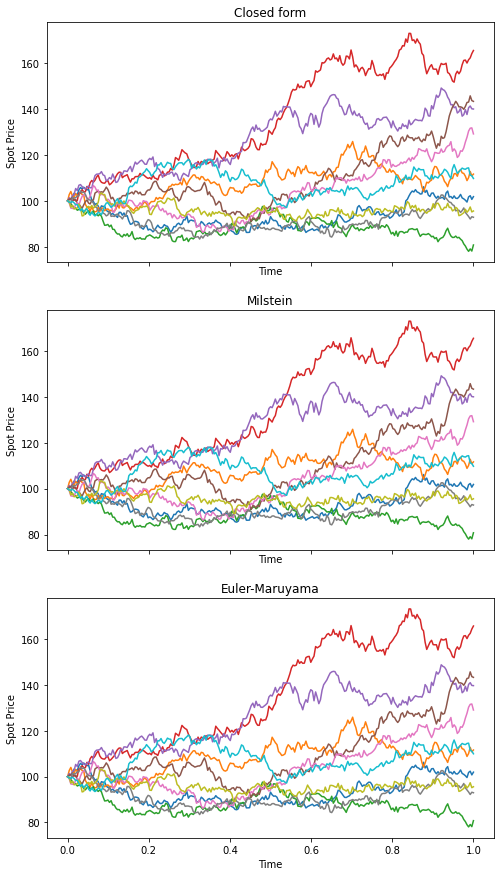

In [18]:
figure, axes = plt.subplots(3, 1, figsize=(8,15), sharex=True)
simulations = [GBM(T, day_count, r, sigma, S_0, 10, random_state=42).T,
               GBM_M(T, day_count, r, sigma, S_0, 10, random_state=42).T,
               GBM_EM(T, day_count, r, sigma, S_0, 10, random_state=42).T]
schemes = ['Closed form', 'Milstein', 'Euler-Maruyama']
for i, s in enumerate(simulations):
    axes[i].plot(np.linspace(0, T, day_count + 1), s)
    axes[i].set_title(schemes[i])
    axes[i].set_xlabel('Time')
    axes[i].set_ylabel('Spot Price')
plt.show()

The simulations obtained by three different methods with given set of parameters look identical to a naked eye. We can take a closer look and illustrate the difference in accuracy between the numerical schemes.

In [5]:
simulations_cf = GBM(T, day_count, r, sigma, S_0, 100000, random_state=42).T
simulations_em = GBM_EM(T, day_count, r, sigma, S_0, 100000, random_state=42).T
simulations_m = GBM_M(T, day_count, r, sigma, S_0, 100000, random_state=42).T

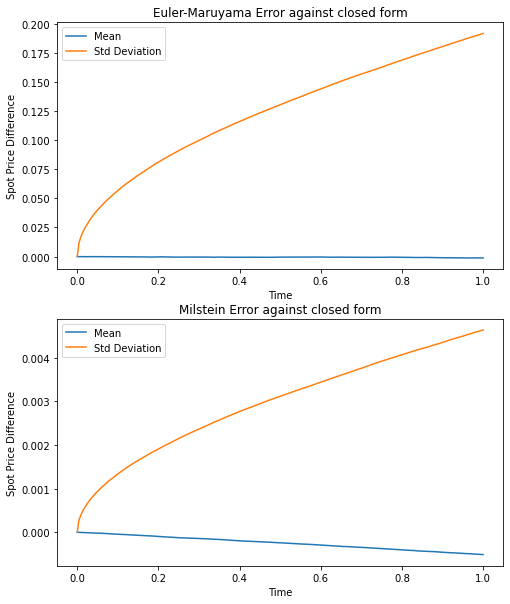

In [19]:
figure, axes = plt.subplots(2, 1, figsize=(8,10))
axes[0].plot(np.linspace(0, T, day_count + 1), (simulations_em - simulations_cf).mean(axis=1), label='Mean')
axes[0].plot(np.linspace(0, T, day_count + 1), (simulations_em - simulations_cf).std(axis=1), label='Std Deviation')
axes[0].set_title('Euler-Maruyama Error against closed form')
axes[0].legend()
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Spot Price Difference')
axes[1].plot(np.linspace(0, T, day_count + 1), (simulations_m - simulations_cf).mean(axis=1), label='Mean')
axes[1].plot(np.linspace(0, T, day_count + 1), (simulations_m - simulations_cf).std(axis=1), label='Std Deviation')
axes[1].set_title('Milstein Error against closed form')
axes[1].legend()
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Spot Price Difference')
plt.show()

Please note the different scaling on y axis of two charts. As we would expect introduction of Milstein correction term to the numerical scheme decreases the error. Also quite expectedly the increase of the accuracy comes at the cost of longer execution time:

In [7]:
%timeit GBM(T, day_count, r, sigma, S_0, 1, random_state=42)
%timeit GBM_M(T, day_count, r, sigma, S_0, 1, random_state=42)
%timeit GBM_EM(T, day_count, r, sigma, S_0, 1, random_state=42)

91.4 µs ± 837 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
3.05 ms ± 185 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.71 ms ± 77.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Conclusion is somewhat standard for this kind of analysis. When applied to real life problem, the choice of simulation method will depends on the model, available resources and the required accuracy. For the asian option valuation under standard BSM-1973 assumptions I am going to use closed form simulations.

We know that the value of value of a derivative contract in our assumptions is equal do its discounted payoff under risk-neutral measure $\mathbb Q$:
$$V(S, t) = e^{-r(T-t)}\mathbb E ^{\mathbb Q}[\text{Payoff}]$$
As we already implemented risk neutral simulations of underlying asset path, we can now approximate the expected value term in the above.

In [8]:
class OptionType(Enum):
    CALL = 0
    PUT = 1
    
class StrikeType(Enum):
    FIXED = 0
    FLOATING = 1

class SamplingType(Enum):
    DISCRETE = 0
    CONTINUOUS = 1

class AverageType(Enum):
    ARITHMETIC = 0
    GEOMETRIC = 1
    
class AsianOption:
    def __init__(self, option_type, strike_type, sampling_type, average_type, 
                 averaging_period_start, time_to_maturity,
                 sampling_freq = None, strike_price=None):
        self.option_type = option_type
        self.strike_type = strike_type
        self.sampling_type = sampling_type
        self.average_type = average_type
        self.averaging_period_start = averaging_period_start
        self.time_to_maturity = time_to_maturity
        self.sampling_freq = sampling_freq
        self.strike_price = strike_price
        
    def get_average(self, hist_prices):
        n = len(hist_prices) - 1
        start = int(n * (averaging_period_start / self.time_to_maturity))
        averaging_period_prices = hist_prices[start:]
        if self.sampling_type == SamplingType.DISCRETE:
            if self.sampling_freq == None:
                raise ValueError("Sampling frequency must be specified for discrete averaging option")
            else:
                k = int( n * self.sampling_freq / self.time_to_maturity)
                if self.average_type == AverageType.ARITHMETIC:
                    average_price = np.mean(averaging_period_prices[::k])
                else:
                    average_price = gmean(averaging_period_prices[::k])
        else:
            if self.average_type == AverageType.ARITHMETIC:
                average_price = np.mean(averaging_period_prices)
            else:
                average_price = gmean(averaging_period_prices)
        return average_price
    
    def get_payoff(self, hist_prices):
        average_price = self.get_average(hist_prices)
        if self.strike_type == StrikeType.FIXED:
            if self.strike_price is None:
                raise ValueError("Strike price must be specified for fixed strike option")
            else:
                if self.option_type == OptionType.CALL:
                    payoff = max(average_price - self.strike_price, 0)
                else:
                    payoff = max(self.strike_price - average_price, 0)
        else:
            if self.option_type == OptionType.CALL:
                payoff = max(hist_prices[-1] - average_price, 0)
            else:
                payoff = max(average_price - hist_prices[-1], 0)
        return payoff
    
    def get_sim_mean(self, simulations):
        payoffs = []
        for i in range(simulations.shape[1]):
            payoffs.append(self.get_payoff(simulations[:,i]))
        return np.array(payoffs).mean()
    
    def get_mc_value(self, S, r, sigma, N, k=10000, random_state=None):
        T = self.time_to_maturity
        simulations_em = GBM(T, N, r, sigma, S, k, random_state=random_state).T
        return exp(-r * T) * self.get_sim_mean(simulations_em)
    
def bsm_value(S, K, T, r, q, sigma, Flag):
    from math import log, sqrt, exp
    from scipy import stats

    S = float(S)
    K = float(K)
    d1 = (log(S/K) + (r - q + 0.5 * sigma ** 2) * T) / (sigma * sqrt(T))
    d2 = (log(S/K) + (r - q - 0.5 * sigma ** 2) * T) / (sigma * sqrt(T))
    if Flag == 0:
        value = (S * exp(-q * T) * stats.norm.cdf(d1, 0.0, 1.0) -
                 K * exp(-r * T) * stats.norm.cdf(d2, 0.0, 1.0))
    elif Flag == 1:
        value = (K * exp(-r * T) * stats.norm.cdf(-d2, 0.0, 1.0) -
                 S * exp(-q * T) * stats.norm.cdf(-d1, 0.0, 1.0))
    else:
        value = 'NaN'
    return value

def tw_asian_value(S, K, T, t1, r, sigma, Flag):
    T2 = T - t1
    tau = -t1
    if r == 0: 
        M1 = 1
        M2 = 2 * exp(T * sigma ** 2) / ((sigma ** 4) * ((T - t1) ** 2)) - \
        2 * exp(t1 * sigma ** 2) * (1 + (T - t1) * sigma ** 2) / ((sigma ** 4) * (T - t1) ** 2)
    else: 
        M1 = (exp(r * T) - exp(r * t1)) / (r * (T - t1))
        M2 = 2 * exp(T * (2 * r + sigma ** 2)) / \
        ((r + sigma ** 2) * (2 * r + sigma ** 2) * (T - t1) ** 2) + \
        2 * exp(t1 * (2 * r + sigma ** 2)) * \
        ((1 / (2 * r + sigma ** 2)) - exp(r * (T - t1)) / (r + sigma ** 2)) / \
        (r * (T - t1) ** 2)
    q = r - log(M1) / T
    v = sqrt((log(M2) / T) - 2 * log(M1) / T)
    return bsm_value(S, K, T, r, q, v, Flag)

Above I coded the Asian option payoff calculation as AsianOption class. Implementation is straightforward but a bit tediuous so apart from standard testing and debugging we can check the results against some well-known closed form solutions or approximations below:

First, if we do the averaging only on one point on the expiry we should expect Asian option to be equivalent to a vanilla

In [9]:
K = 100
print("Black-Scholes value for vanilla case")
print("call: %.2f, put: %.2f" % (bsm_value(S_0, K, T, r, 0, sigma, 0),
      bsm_value(S_0, K, T, r, 0, sigma, 1)))

vanilla_call_mc = exp(-r * T) * ((simulations_cf[-1,:] - K) * (simulations_cf[-1,:] > K)).mean()
vanilla_put_mc = exp(-r * T) * ((K - simulations_cf[-1,:]) * (simulations_cf[-1,:] < K)).mean()
strike_type = StrikeType.FIXED
average_type = AverageType.GEOMETRIC
sampling_type = SamplingType.CONTINUOUS 
averaging_period_start = T

call = AsianOption(OptionType.CALL, strike_type, sampling_type, average_type, 
                 averaging_period_start, T, strike_price=100)
put = AsianOption(OptionType.PUT, strike_type, sampling_type, average_type, 
                 averaging_period_start, T, strike_price=100)
print("Monte Carlo value for reduced case of Asian option")
print("call: %.2f, put: %.2f" % (exp(-r * T) * call.get_sim_mean(simulations_cf), 
      exp(-r * T) * put.get_sim_mean(simulations_cf)))
print("Manual Monte Carlo value for reduced case of Asian option")
print("call: %.2f, put: %.2f" % (vanilla_call_mc, vanilla_put_mc))

Black-Scholes value for vanilla case
call: 10.45, put: 5.57
Monte Carlo value for reduced case of Asian option
call: 10.40, put: 5.55
Manual Monte Carlo value for reduced case of Asian option
call: 10.40, put: 5.55


Now we can use a well-known closed form solution for a geometric average Asian option:

In [10]:
print("Closed form solution for continuous geometric averaging case")
print("call: %.2f, put: %.2f" %
      (bsm_value(S_0, K, T, r, r - 0.5 * (r - (sigma ** 2) / 6), sigma / sqrt(3), 0),
      bsm_value(S_0, K, T, r, r - 0.5 * (r - (sigma ** 2) / 6), sigma / sqrt(3), 1)))

strike_type = StrikeType.FIXED
average_type = AverageType.GEOMETRIC
sampling_type = SamplingType.CONTINUOUS 
averaging_period_start = 0

call = AsianOption(OptionType.CALL, strike_type, sampling_type, average_type, 
                 averaging_period_start, T, strike_price=100)
put = AsianOption(OptionType.PUT, strike_type, sampling_type, average_type, 
                 averaging_period_start, T, strike_price=100)
print("Monte Carlo value for 'continuous' geometric averaging case")
print("call: %.2f, put: %.2f" %
      (exp(-r * T) * call.get_sim_mean(simulations_cf),
       exp(-r * T) * put.get_sim_mean(simulations_cf)))

Closed form solution for continuous geometric averaging case
call: 5.55, put: 3.46
Monte Carlo value for 'continuous' geometric averaging case
call: 5.52, put: 3.48


Here I put quotes around continuous for Monte-Carlo calculation because daily prices average is used. Probably some scholars can become mad but I believe daily data is used by practitioners when they call an option 'continuous'.

Arithmetic average case does not have a closed form solution but we can utilise Turnbull-Wakeman aproximation

In [11]:
print("Turnbull-Wakeman approximation for arithmetic averaging asian option")
print("call: %.2f, put: %.2f" %
    (tw_asian_value(S_0, K, T, 0, r, sigma, 0),
     tw_asian_value(S_0, K, T, 0, r, sigma, 1)))
strike_type = StrikeType.FIXED
average_type = AverageType.ARITHMETIC
sampling_type = SamplingType.CONTINUOUS 
averaging_period_start = 0

call = AsianOption(OptionType.CALL, strike_type, sampling_type, average_type, 
                 averaging_period_start, T, strike_price=100)
put = AsianOption(OptionType.PUT, strike_type, sampling_type, average_type, 
                 averaging_period_start, T, strike_price=100)
print("Monte Carlo value for 'continuous' arithmetic averaging case")
print("call: %.2f, put: %.2f" %
      (exp(-r * T) * call.get_sim_mean(simulations_cf),
       exp(-r * T) * put.get_sim_mean(simulations_cf)))

Turnbull-Wakeman approximation for arithmetic averaging asian option
call: 5.78, put: 3.36
Monte Carlo value for 'continuous' arithmetic averaging case
call: 5.74, put: 3.36


To test the implementation of floating strike type we can utilise fixed and floating stirkes symmetry for geomertric in continuous averaging case:

In [12]:
option_type = OptionType.CALL
strike_type = StrikeType.FIXED
average_type = AverageType.GEOMETRIC
sampling_type = SamplingType.CONTINUOUS 
averaging_period_start = 0

option1 = AsianOption(option_type, strike_type, sampling_type, average_type, 
                 averaging_period_start, T,
                    strike_price=100)

option_type = OptionType.PUT
strike_type = StrikeType.FLOATING

option2 = AsianOption(option_type, strike_type, sampling_type, average_type, 
                 averaging_period_start, T,
                    strike_price=1)

print("fixed strike call: %.2f, floating strike put: %.2f" %
      (option1.get_mc_value(100, 0, 0.2, 252, 100000, 42),
       option2.get_mc_value(100, 0, 0.2, 252, 100000, 42)))

fixed strike call: 4.40, floating strike put: 4.40


Now as we have a bit more confidence in the implementation we can compare the values of different types of asian option together with vanilla european options:

In [13]:
option_types = [OptionType.CALL, OptionType.PUT]
strike_types = [StrikeType.FIXED, StrikeType.FLOATING]
average_types = [AverageType.ARITHMETIC, AverageType.GEOMETRIC]
sampling_types = [SamplingType.CONTINUOUS, SamplingType.DISCRETE]
all_types = [(t1, t2, t3, t4) for t1 in option_types for t2 in strike_types for t3 in average_types
             for t4 in sampling_types]
averaging_period_start = 0
sampling_freq = 0.25
output_table = pd.DataFrame(columns=['Option Type', 'Strike Type', 'Average Type',
                                    'Sampling Type', 'Monte Carlo Price'])
new_row = {'Option Type' : 'CALL',
           'Strike Type' : 'FIXED',
           'Average Type' : 'VANILLA',
           'Sampling Type' : 'VANILLA',
           'Monte Carlo Price' : vanilla_call_mc}
output_table = output_table.append(new_row, ignore_index=True)
new_row = {'Option Type' : 'PUT',
           'Strike Type' : 'FIXED',
           'Average Type' : 'VANILLA',
           'Sampling Type' : 'VANILLA',
           'Monte Carlo Price' : vanilla_put_mc}
output_table = output_table.append(new_row, ignore_index=True)
for t in all_types:
    (option_type, strike_type, average_type, sampling_type) = t
    option = AsianOption(option_type, strike_type, sampling_type, average_type, 
                 averaging_period_start, T, sampling_freq, strike_price=100)
    value = exp(-r * T) * option.get_sim_mean(simulations_cf)
    new_row = {'Option Type' : str(option_type).split('.')[1],
              'Strike Type' : str(strike_type).split('.')[1],
              'Average Type' : str(average_type).split('.')[1],
              'Sampling Type' : str(sampling_type).split('.')[1],
              'Monte Carlo Price' : value}
    output_table = output_table.append(new_row, ignore_index=True)
output_table.style.format('{:.2f}', subset=['Monte Carlo Price']).hide_index()

Option Type,Strike Type,Average Type,Sampling Type,Monte Carlo Price
CALL,FIXED,VANILLA,VANILLA,10.40
PUT,FIXED,VANILLA,VANILLA,5.55
CALL,FIXED,ARITHMETIC,CONTINUOUS,5.74
CALL,FIXED,ARITHMETIC,DISCRETE,5.53
CALL,FIXED,GEOMETRIC,CONTINUOUS,5.52
CALL,FIXED,GEOMETRIC,DISCRETE,5.27
CALL,FLOATING,ARITHMETIC,CONTINUOUS,5.84
CALL,FLOATING,ARITHMETIC,DISCRETE,5.60
CALL,FLOATING,GEOMETRIC,CONTINUOUS,6.05
CALL,FLOATING,GEOMETRIC,DISCRETE,5.86


Being a person who never priced or traded Asian options before, I only heard the opinion that Asian options were simply cheaper variations of vanilla (although higher protection from spot market manipulation also comes to mind). There is some obvious logic behind it since average price is less volatile than spot price. Results above also speak in favour of such opinion. However, we probably should consider wider range of scenarios to get a better feel of the nuances.

For brevity purposes in the analysis below I decided to pick a single type of Asian option and same analysis for the rest of option types is omitted from final version of the assingmgnet (in my opinion without any loss of significance). As for benchmark for comparison I choose vanilla option, so fixed type of strike is more comparable. We may say that continuous sampling type of option is in a sense more 'Asian' than discrete. Also I pick arithmetic averaging because for geometric averaging we can use closed form solution and doing Monte-Carlo seems unnecessary.

In [14]:
S_space = np.linspace(51, 150, 100)
values_S_calls = []
values_S_puts = []
values_S_vanilla_calls = []
values_S_vanilla_puts = []

K_space = np.linspace(51, 150, 100)
values_K_calls = []
values_K_puts = []
values_K_vanilla_calls = []
values_K_vanilla_puts = []

r_space = np.linspace(0.005, 0.1, 20)
values_r_calls = []
values_r_puts = []
values_r_vanilla_calls = []
values_r_vanilla_puts = []

days_space = np.linspace(21, 501, 97)
values_days_calls = []
values_days_puts = []
values_days_vanilla_calls = []
values_days_vanilla_puts = []

sigma_space = np.linspace(0.11, 0.3, 20)
values_sigma_calls = []
values_sigma_puts = []
values_sigma_vanilla_calls = []
values_sigma_vanilla_puts = []


strike_type = StrikeType.FIXED
average_type = AverageType.ARITHMETIC
sampling_type = SamplingType.CONTINUOUS 
averaging_period_start = 0

call_option = AsianOption(OptionType.CALL, strike_type, sampling_type, average_type,
                     averaging_period_start, T, strike_price=K)
put_option = AsianOption(OptionType.PUT, strike_type, sampling_type, average_type,
                     averaging_period_start, T, strike_price=K)
for S in S_space:
    simulations = GBM(T, day_count, r, sigma, S, 10000, random_state=42).T
    values_S_calls.append(exp(-r * T) * call_option.get_sim_mean(simulations))
    values_S_puts.append(exp(-r * T) * put_option.get_sim_mean(simulations))
    values_S_vanilla_calls.append(bsm_value(S, K, T, r, 0, sigma, 0))
    values_S_vanilla_puts.append(bsm_value(S, K, T, r, 0, sigma, 1))
for rate in r_space: 
    simulations = GBM(T, day_count, rate, sigma, S_0, 10000, random_state=42).T
    values_r_calls.append(exp(-rate * T) * call_option.get_sim_mean(simulations))
    values_r_puts.append(exp(-rate * T) * put_option.get_sim_mean(simulations))
    values_r_vanilla_calls.append(bsm_value(S_0, K, T, rate, 0, sigma, 0))
    values_r_vanilla_puts.append(bsm_value(S_0, K, T, rate, 0, sigma, 1))
for vol in sigma_space:
    simulations = GBM(T, day_count, r, vol, S_0, 10000, random_state=42).T
    values_sigma_calls.append(exp(-r * T) * call_option.get_sim_mean(simulations))
    values_sigma_puts.append(exp(-r * T) * put_option.get_sim_mean(simulations))
    values_sigma_vanilla_calls.append(bsm_value(S_0, K, T, r, 0, vol, 0))
    values_sigma_vanilla_puts.append(bsm_value(S_0, K, T, r, 0, vol, 1))
simulations = GBM(T, day_count, r, sigma, S_0, 10000, random_state=42).T
for strike in K_space:
    call_option = AsianOption(OptionType.CALL, strike_type, sampling_type, average_type,
                     averaging_period_start, T, strike_price=strike)
    put_option = AsianOption(OptionType.PUT, strike_type, sampling_type, average_type,
                     averaging_period_start, T, strike_price=strike)
    values_K_calls.append(exp(-r * T) * call_option.get_sim_mean(simulations))
    values_K_puts.append(exp(-r * T) * put_option.get_sim_mean(simulations))
    values_K_vanilla_calls.append(bsm_value(S_0, strike, T, r, 0, sigma, 0))
    values_K_vanilla_puts.append(bsm_value(S_0, strike, T, r, 0, sigma, 1))
simulations = GBM(2, 2 * day_count, r, sigma, S_0, 10000, random_state=42).T
for days in days_space:
    call_option = AsianOption(OptionType.CALL, strike_type, sampling_type, average_type,
                     averaging_period_start, days / day_count, strike_price=K)
    put_option = AsianOption(OptionType.PUT, strike_type, sampling_type, average_type,
                     averaging_period_start, days / day_count, strike_price=K)
    values_days_calls.append(exp(-r * (days / day_count)) * call_option.get_sim_mean(simulations[:int(days)]))
    values_days_puts.append(exp(-r * (days / day_count)) * put_option.get_sim_mean(simulations[:int(days)]))
    values_days_vanilla_calls.append(bsm_value(S_0, K, (days / day_count), r, 0, sigma, 0))
    values_days_vanilla_puts.append(bsm_value(S_0, K, (days / day_count), r, 0, sigma, 1))

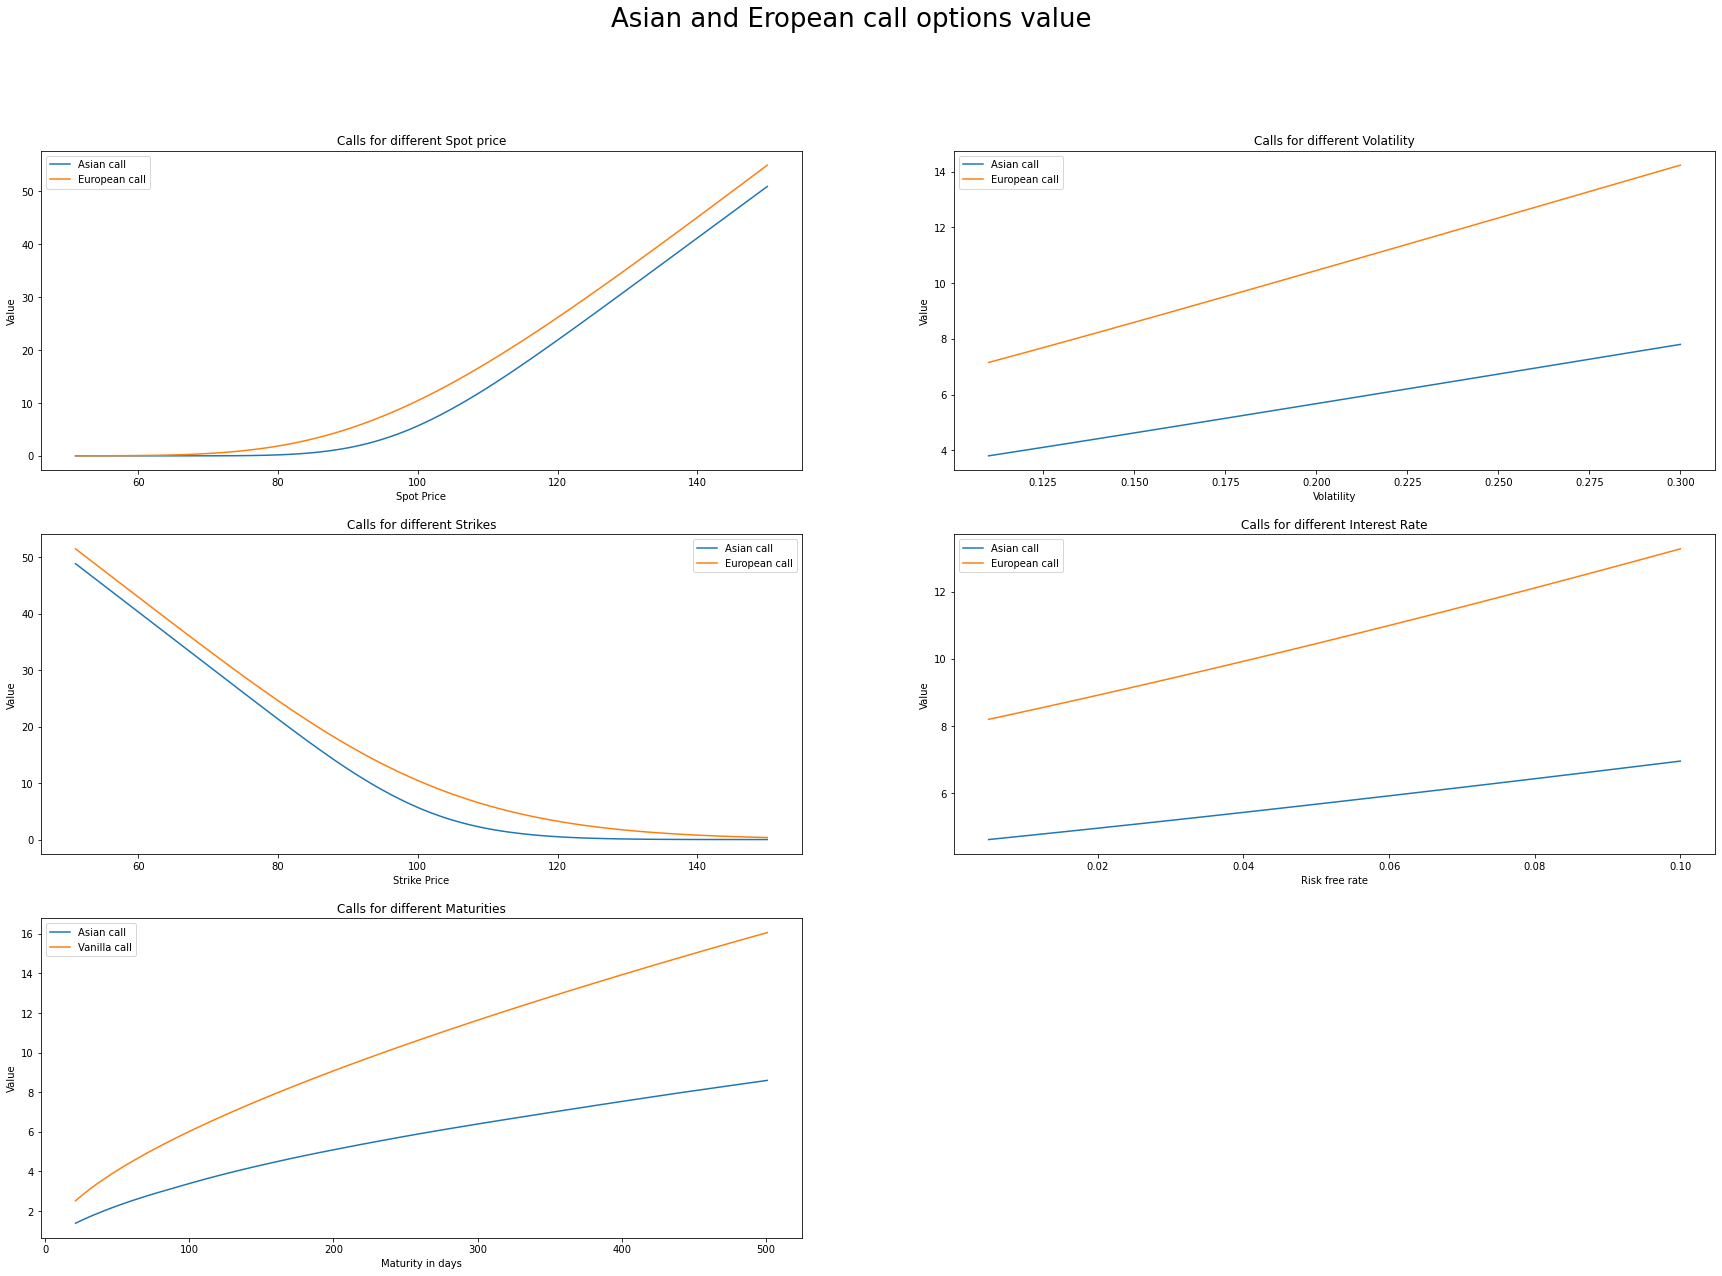

In [24]:
figure, axes = plt.subplots(3, 2, figsize=(30, 20))
figure.suptitle('Asian and Eropean call options value', fontsize=26)
axes[0,0].plot(S_space, values_S_calls, label='Asian call')
axes[0,0].plot(S_space, values_S_vanilla_calls, label='European call')
axes[0,0].set_title('Calls for different Spot price')
axes[0,0].legend()
axes[0,0].set_xlabel('Spot Price')
axes[0,0].set_ylabel('Value')
axes[0,1].plot(sigma_space, values_sigma_calls, label='Asian call')
axes[0,1].plot(sigma_space, values_sigma_vanilla_calls, label='European call')
axes[0,1].set_title('Calls for different Volatility')
axes[0,1].legend()
axes[0,1].set_xlabel('Volatility')
axes[0,1].set_ylabel('Value')
axes[1,1].plot(r_space, values_r_calls, label='Asian call')
axes[1,1].plot(r_space, values_r_vanilla_calls, label='European call')
axes[1,1].set_title('Calls for different Interest Rate')
axes[1,1].legend()
axes[1,1].set_xlabel('Risk free rate')
axes[1,1].set_ylabel('Value')
axes[1,0].plot(K_space, values_K_calls, label='Asian call')
axes[1,0].plot(K_space, values_K_vanilla_calls, label='European call')
axes[1,0].set_title('Calls for different Strikes')
axes[1,0].legend()
axes[1,0].set_xlabel('Strike Price')
axes[1,0].set_ylabel('Value')
axes[2,0].plot(days_space, values_days_calls, label='Asian call')
axes[2,0].plot(days_space, values_days_vanilla_calls, label='Vanilla call')
axes[2,0].set_title('Calls for different Maturities')
axes[2,0].legend()
axes[2,0].set_xlabel('Maturity in days')
axes[2,0].set_ylabel('Value')
axes[2,1].axis('off')
plt.show()

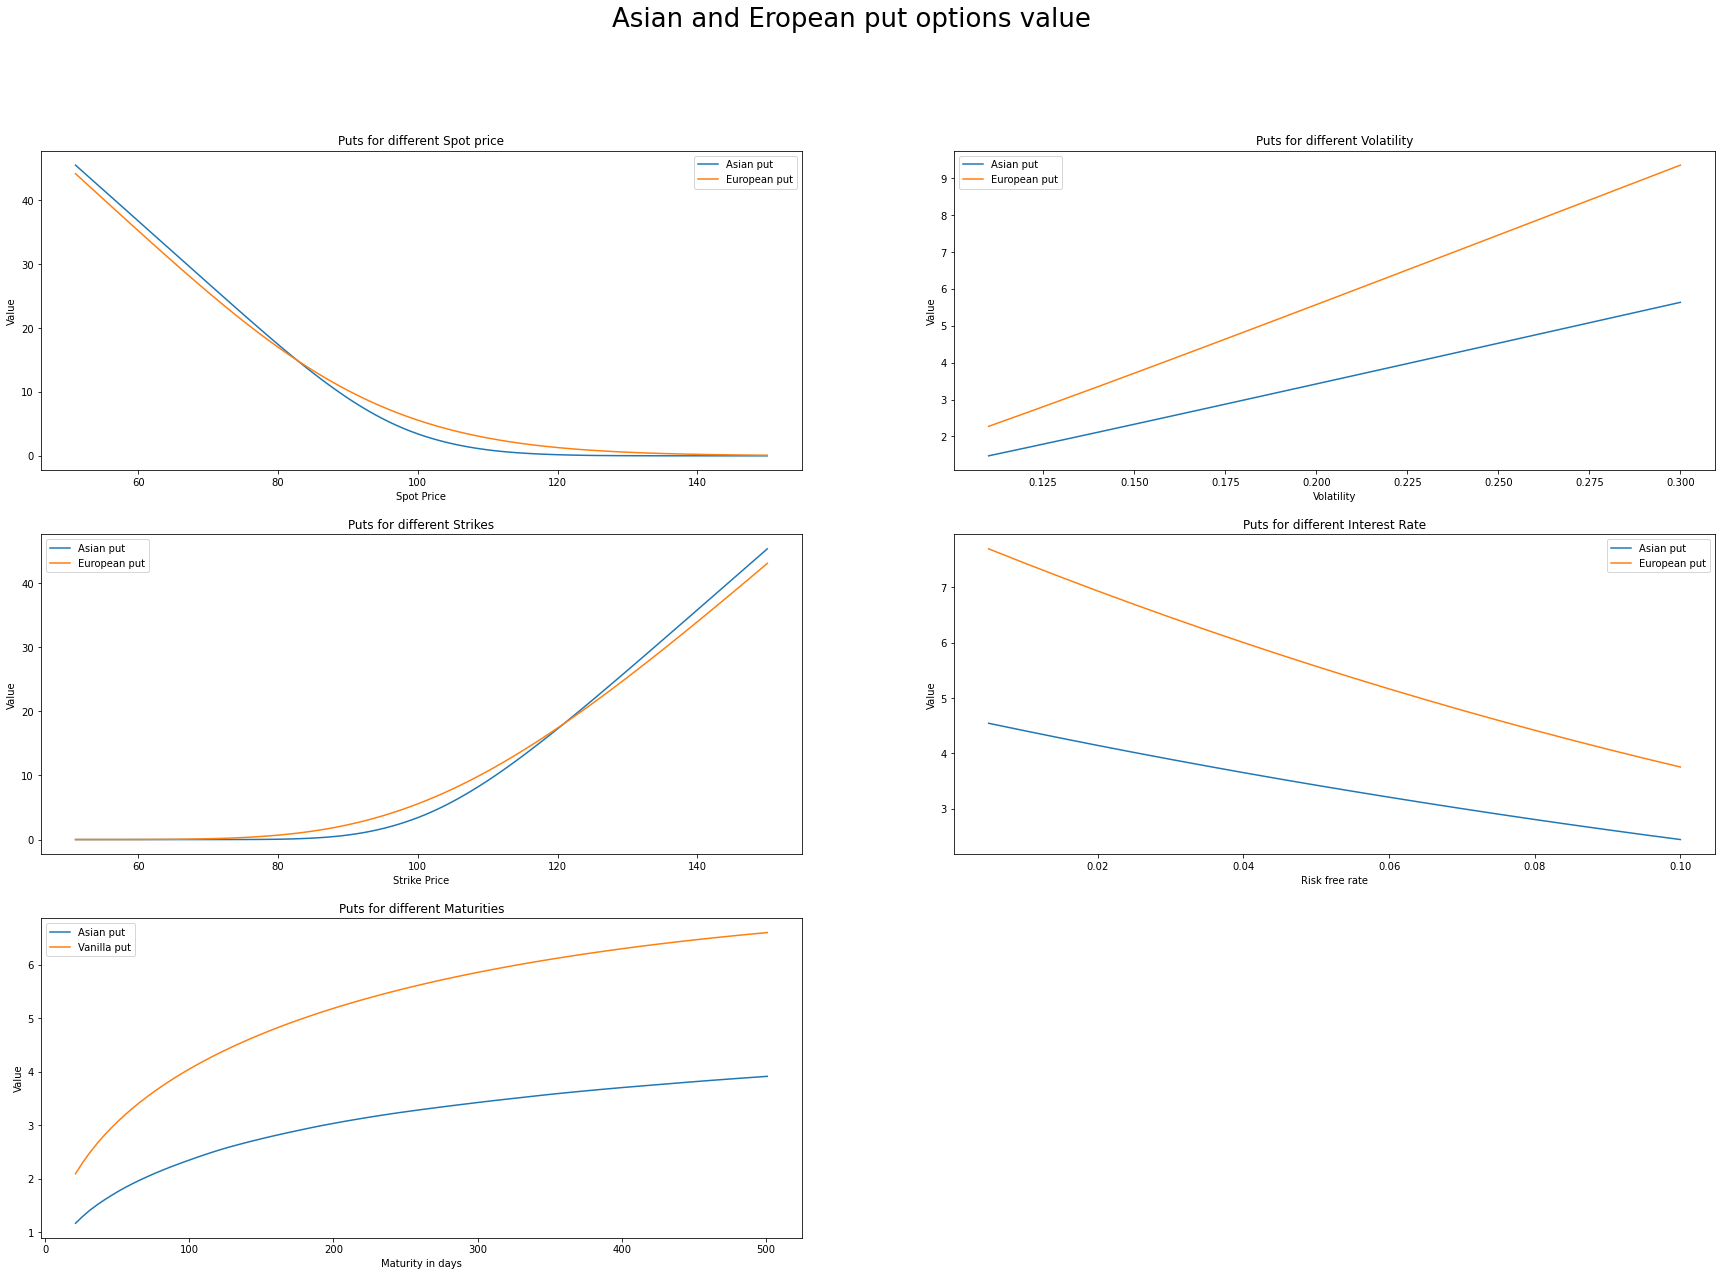

In [25]:
figure, axes = plt.subplots(3, 2, figsize=(30, 20))
figure.suptitle('Asian and European put options value', fontsize=26)
axes[0,0].plot(S_space, values_S_puts, label='Asian put')
axes[0,0].plot(S_space, values_S_vanilla_puts, label='European put')
axes[0,0].set_title('Puts for different Spot price')
axes[0,0].legend()
axes[0,0].set_xlabel('Spot Price')
axes[0,0].set_ylabel('Value')
axes[0,1].plot(sigma_space, values_sigma_puts, label='Asian put')
axes[0,1].plot(sigma_space, values_sigma_vanilla_puts, label='European put')
axes[0,1].set_title('Puts for different Volatility')
axes[0,1].legend()
axes[0,1].set_xlabel('Volatility')
axes[0,1].set_ylabel('Value')
axes[1,1].plot(r_space, values_r_puts, label='Asian put')
axes[1,1].plot(r_space, values_r_vanilla_puts, label='European put')
axes[1,1].set_title('Puts for different Interest Rate')
axes[1,1].legend()
axes[1,1].set_xlabel('Risk free rate')
axes[1,1].set_ylabel('Value')
axes[1,0].plot(K_space, values_K_puts, label='Asian put')
axes[1,0].plot(K_space, values_K_vanilla_puts, label='European put')
axes[1,0].set_title('Puts for different Strikes')
axes[1,0].legend()
axes[1,0].set_xlabel('Strike Price')
axes[1,0].set_ylabel('Value')
axes[2,0].plot(days_space, values_days_puts, label='Asian put')
axes[2,0].plot(days_space, values_days_vanilla_puts, label='Vanilla put')
axes[2,0].set_title('Puts for different Maturities')
axes[2,0].legend()
axes[2,0].set_xlabel('Maturity in days')
axes[2,0].set_ylabel('Value')
axes[2,1].axis('off')
plt.show()

From the charts we can see that Asian options' properties are similar to the ones of vanilla (at least qualitatively) and in most cases it is true that Asian option is cheaper variation of vanilla. However, we can see that it does not hold for deep in the money puts and vanilla value lies below the asian. We know that in-the-money options generally can be rather sensitive to the cost of carry and potentially less sensitive to the volaility as their intrincsic value becomes higher and their time value becomes lower (alterantively we can think about the effects of drift and diffusion to sound more like quants). In case of in the money puts, asian options benefit from the fact that as the spot price drifts higher, average price is expected to be lower than price at maturity. If this effect is really the main driver of charts above, then it should become stronger as we consider higher interest rate and lower vol. And by stronger effect I mean that difference between their value should increase in favor of the asian and their intersection should be closer to at the money. To illustrate we can use the example of $\sigma_{-}=0.15$ and $r_{+}=0.1$ to calculate new option value $V^*$ and see if the described effect really appears: 

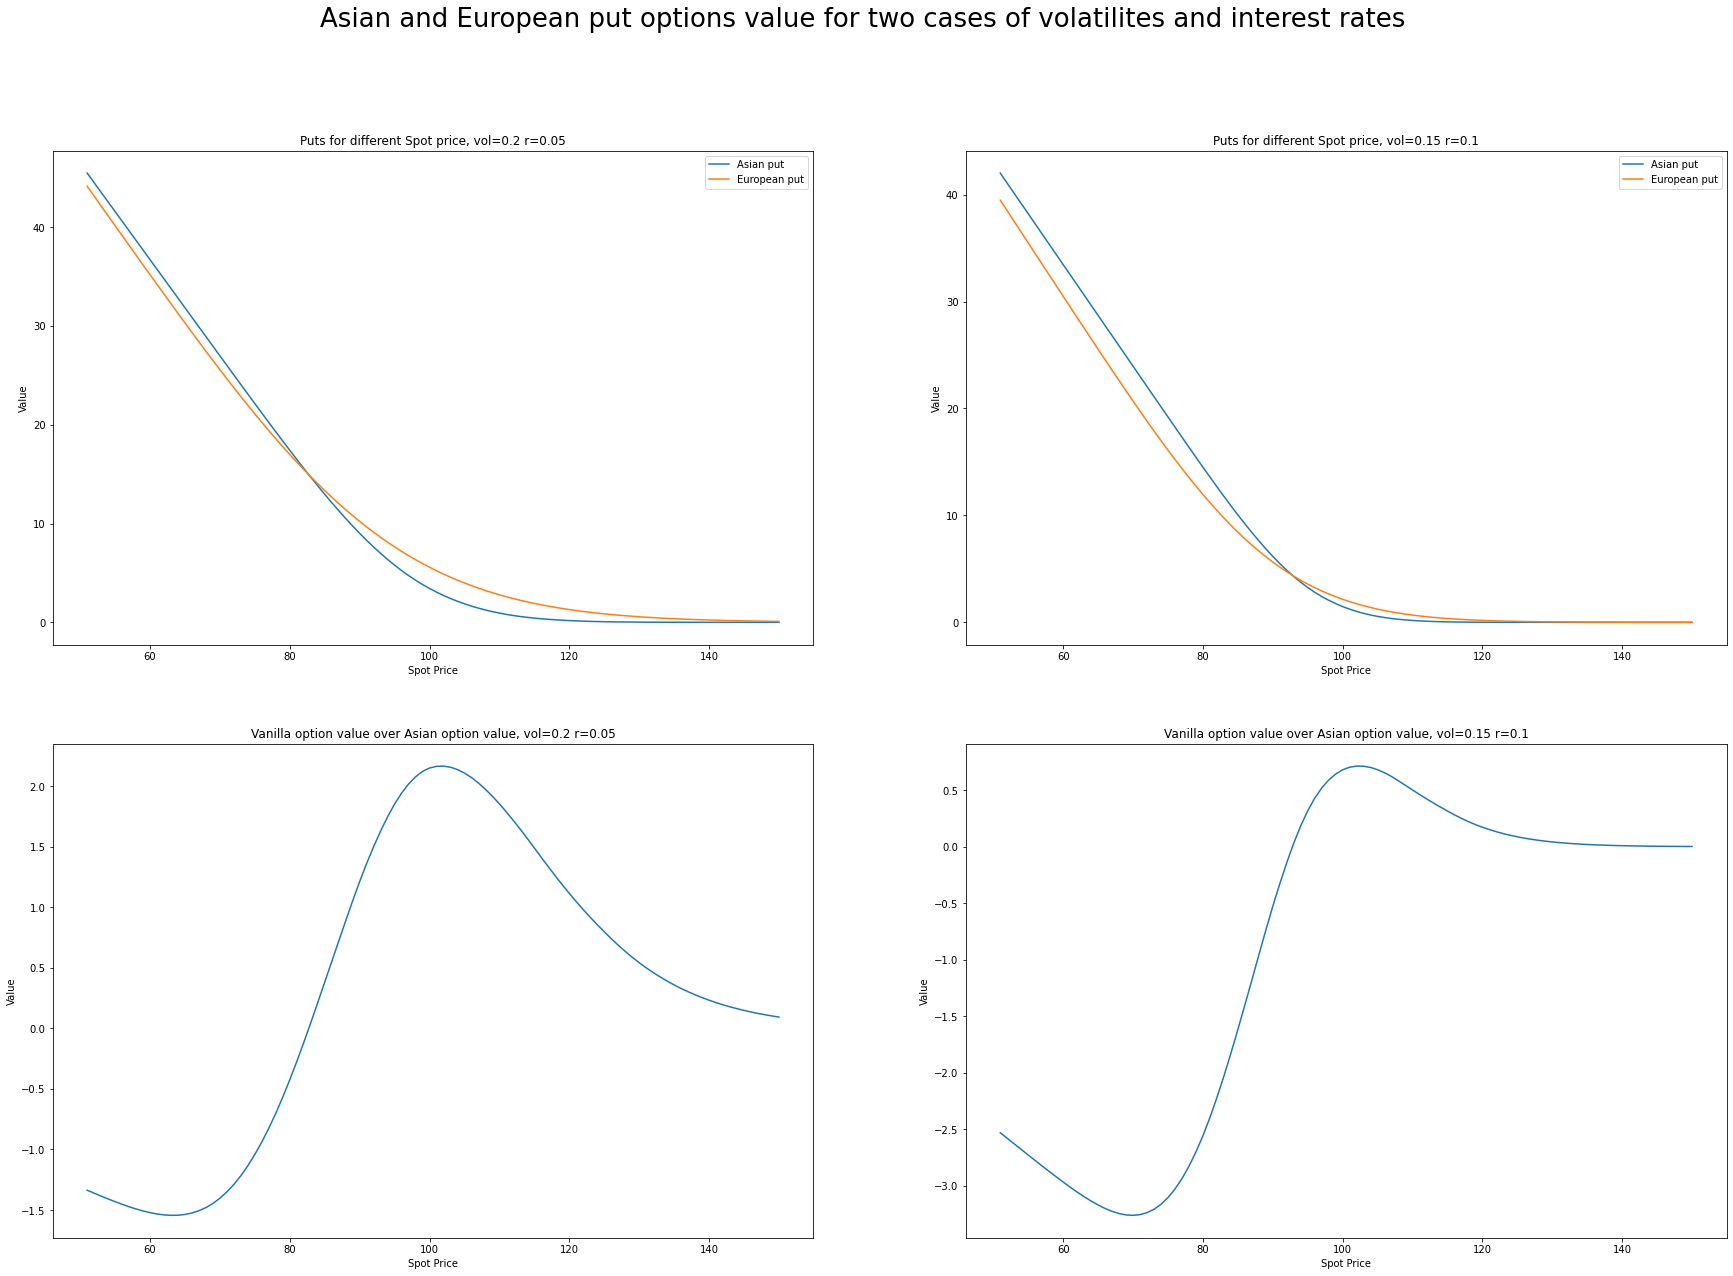

In [35]:
r_plus = 0.1
sigma_minus = 0.15

values_S_puts_star = []
values_S_vanilla_puts_star = []

put_option = AsianOption(OptionType.PUT, strike_type, sampling_type, average_type,
                     averaging_period_start, T, strike_price=K)
for S in S_space:
    simulations = GBM(T, day_count, r_plus, sigma_minus, S, 10000, random_state=42).T
    values_S_puts_star.append(exp(-r_plus * T) * put_option.get_sim_mean(simulations))
    values_S_vanilla_puts_star.append(bsm_value(S, K, T, r_plus, 0, sigma_minus, 1))

figure, axes = plt.subplots(2, 2, figsize=(30, 20))
figure.suptitle('Asian and European put options value for two cases of volatilites and interest rates', fontsize=26)
axes[0,0].plot(S_space, values_S_puts, label='Asian put')
axes[0,0].plot(S_space, values_S_vanilla_puts, label='European put')
axes[0,0].set_title('Puts for different Spot price, vol=0.2 r=0.05')
axes[0,0].legend()
axes[0,0].set_xlabel('Spot Price')
axes[0,0].set_ylabel('Value')
axes[1,0].plot(S_space, np.array(values_S_vanilla_puts) - np.array(values_S_puts),)
axes[1,0].set_xlabel('Spot Price')
axes[1,0].set_ylabel('Value')
axes[1,0].set_title('Vanilla option value over Asian option value, vol=0.2 r=0.05')
axes[0,1].plot(S_space, values_S_puts_star, label='Asian put')
axes[0,1].plot(S_space, values_S_vanilla_puts_star, label='European put')
axes[0,1].set_title('Puts for different Spot price, vol=0.15 r=0.1')
axes[0,1].legend()
axes[0,1].set_xlabel('Spot Price')
axes[0,1].set_ylabel('Value')
axes[1,1].plot(S_space, np.array(values_S_vanilla_puts_star) - np.array(values_S_puts_star))
axes[1,1].set_xlabel('Spot Price')
axes[1,1].set_ylabel('Value')
axes[1,1].set_title('Vanilla option value over Asian option value, vol=0.15 r=0.1')
plt.show()

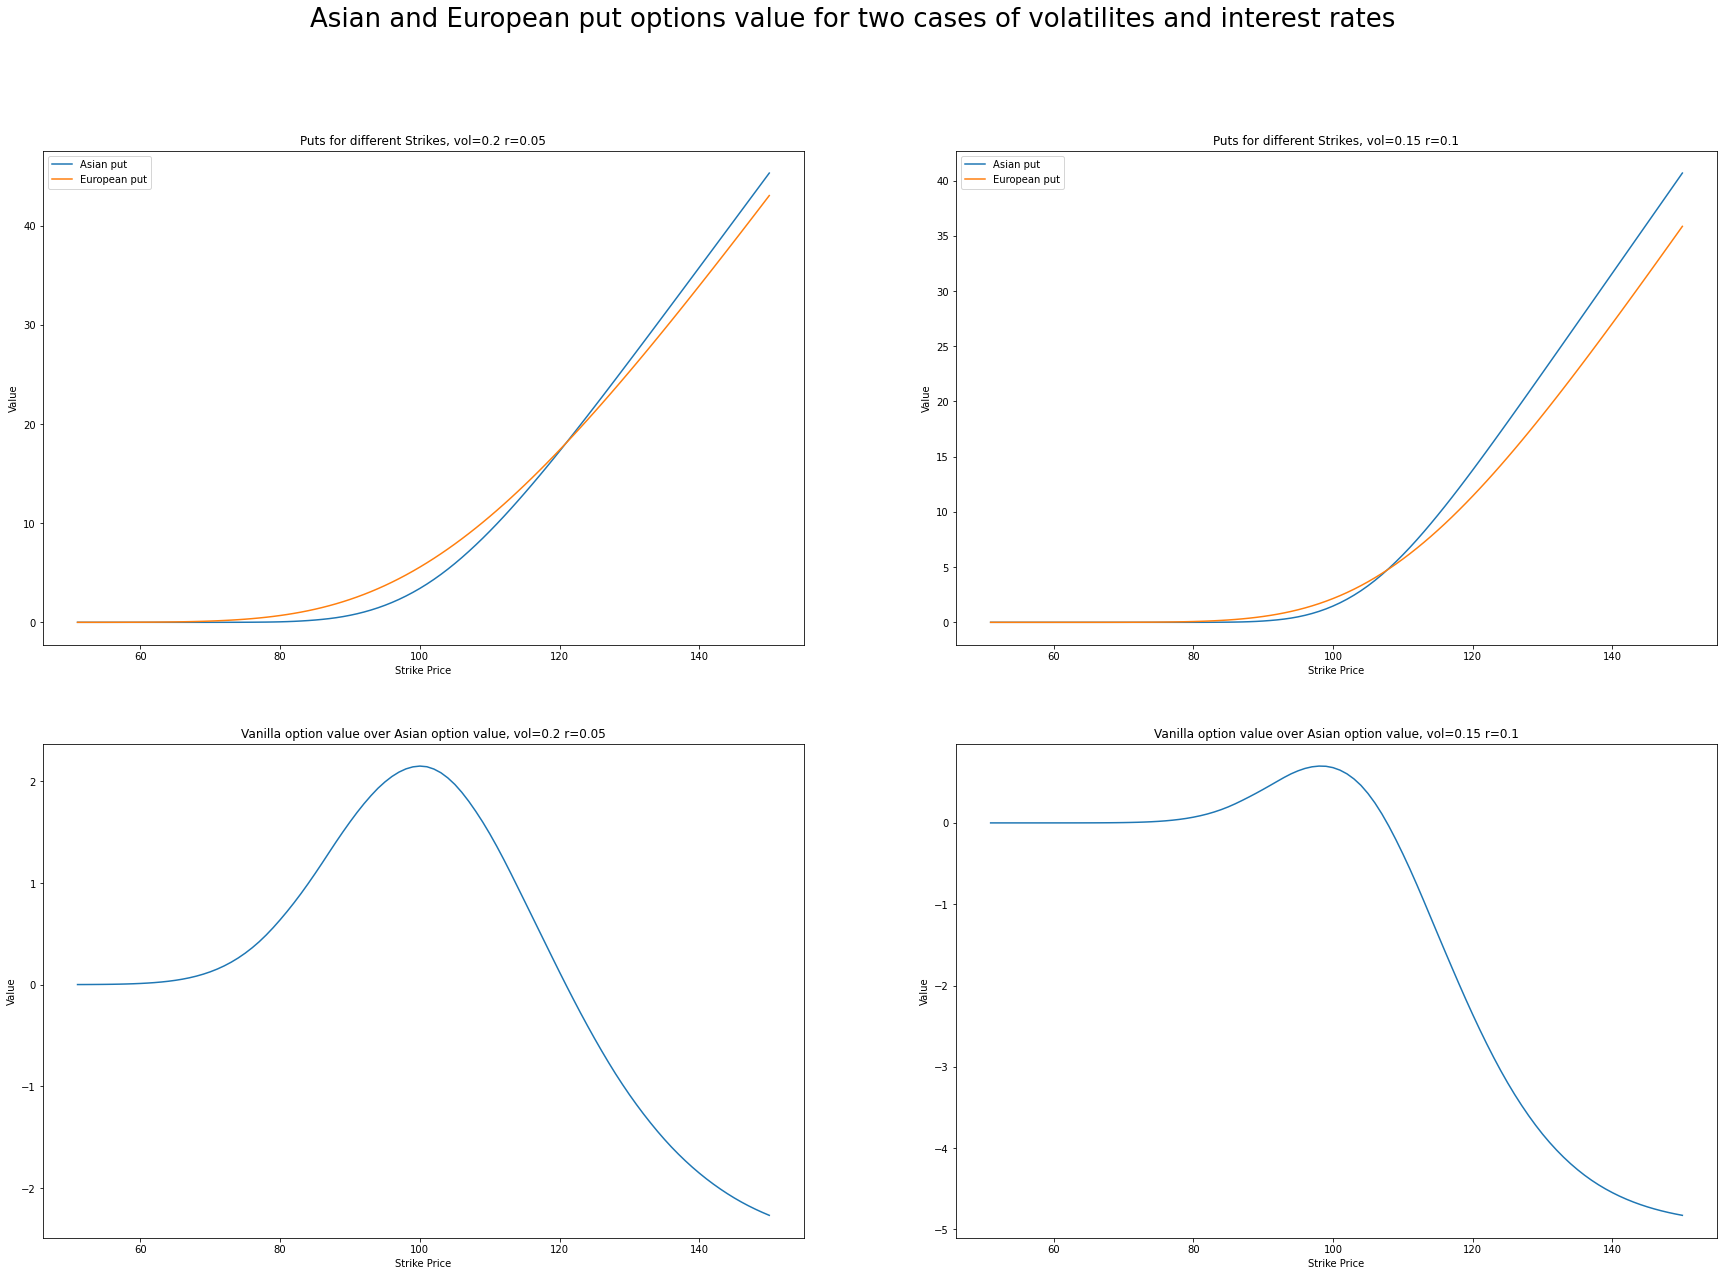

In [32]:
values_K_puts_star = []
values_K_vanilla_puts_star = []

simulations = GBM(T, day_count, r_plus, sigma_minus, S_0, 10000, random_state=42).T
for strike in K_space:
    put_option = AsianOption(OptionType.PUT, strike_type, sampling_type, average_type,
                     averaging_period_start, T, strike_price=strike)
    values_K_puts_star.append(exp(-r_plus * T) * put_option.get_sim_mean(simulations))
    values_K_vanilla_puts_star.append(bsm_value(S_0, strike, T, r_plus, 0, sigma_minus, 1))

figure, axes = plt.subplots(2, 2, figsize=(30, 20))
figure.suptitle('Asian and European put options value for two cases of volatilites and interest rates', fontsize=26)
axes[0,0].plot(K_space, values_K_puts, label='Asian put')
axes[0,0].plot(K_space, values_K_vanilla_puts, label='European put')
axes[0,0].set_title('Puts for different Strikes, vol=0.2 r=0.05')
axes[0,0].legend()
axes[0,0].set_xlabel('Strike Price')
axes[0,0].set_ylabel('Value')
axes[1,0].plot(K_space, np.array(values_K_vanilla_puts) - np.array(values_K_puts))
axes[1,0].set_xlabel('Strike Price')
axes[1,0].set_ylabel('Value')
axes[1,0].set_title('Vanilla option value over Asian option value, vol=0.2 r=0.05')
axes[0,1].plot(K_space, values_K_puts_star, label='Asian put')
axes[0,1].plot(K_space, values_K_vanilla_puts_star, label='European put')
axes[0,1].set_title('Puts for different Strikes, vol=0.15 r=0.1')
axes[0,1].legend()
axes[0,1].set_xlabel('Strike Price')
axes[0,1].set_ylabel('Value')
axes[1,1].plot(S_space, np.array(values_K_vanilla_puts_star) - np.array(values_K_puts_star))
axes[1,1].set_xlabel('Strike Price')
axes[1,1].set_ylabel('Value')
axes[1,1].set_title('Vanilla option value over Asian option value, vol=0.15 r=0.1')
plt.show()

Charts above speak in favor of the explanation that was given earlier. Of course rather than use the computations we could think of example of a process with a constant drift but zero diffusion. In this case asian puts are either more expensive than european or their both values are zeros. For some subset eurpoean value is equal to 0 while asian value is positive.

To conclude, the argument that asian options are used when one needs to cheapen the european is although often correct in practice but still needs to be handeled with caution. More generally speaking, 'moneyness' of the option is different for asian and european classes. One extremely obvious consequence of it is that when using the asian option instead of european in practice one needs to consider strike adjustment (or may be also maturity adjustment). Another less obvious result is that, even though under assumptions of BSM-1973 Monte-Carlo simualtions method is convenient and simple and in some cases we have closed-forms or approximations, when facing the valuation of asian options in real life there is a question of picking correct volatility and even interest rate (this one should be easier though). In the presence of non-flat volatility surface for vanillas, given the described effect, it can be wrong to simply use the volatility of the same strike and maturity. And it is not immediately clear which point on the surface should be the input for the asian option valuation. Probably a single volatility point may not be enough in practice. If my carreer relied on adequate pricing and valuation of asian options, I would start looking at more advanced models which are calibrated to the whole volatility surface rather than to one constant value.

# Task 2